In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/Shareddrives/CS229Buddies/project')

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_precision_recall_curve
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import operator
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [5]:
df=pd.read_csv("data/KEGG_matrix.csv")
df=df.T
df.columns=df.iloc[0,:]
df=df.iloc[1:,:]

In [6]:
df

Term|NES,ABC transporters,AGE-RAGE signaling pathway in diabetic complications,AMPK signaling pathway,Acute myeloid leukemia,Adherens junction,Adipocytokine signaling pathway,Adrenergic signaling in cardiomyocytes,African trypanosomiasis,"Alanine, aspartate and glutamate metabolism",Alcoholism,Aldosterone synthesis and secretion,Aldosterone-regulated sodium reabsorption,Allograft rejection,Alzheimer disease,Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRNA biosynthesis,Amoebiasis,Amphetamine addiction,Amyotrophic lateral sclerosis (ALS),Antigen processing and presentation,Apelin signaling pathway,Apoptosis,Arachidonic acid metabolism,Arginine and proline metabolism,Arrhythmogenic right ventricular cardiomyopathy (ARVC),Ascorbate and aldarate metabolism,Asthma,Autoimmune thyroid disease,Autophagy,Axon guidance,B cell receptor signaling pathway,Bacterial invasion of epithelial cells,Basal cell carcinoma,Basal transcription factors,Base excision repair,Bile secretion,Biosynthesis of unsaturated fatty acids,Bladder cancer,Breast cancer,Butanoate metabolism,...,Steroid hormone biosynthesis,Synaptic vesicle cycle,Systemic lupus erythematosus,T cell receptor signaling pathway,TGF-beta signaling pathway,TNF signaling pathway,Taste transduction,Terpenoid backbone biosynthesis,Th1 and Th2 cell differentiation,Th17 cell differentiation,Thermogenesis,Thyroid cancer,Thyroid hormone signaling pathway,Thyroid hormone synthesis,Tight junction,Toll-like receptor signaling pathway,Toxoplasmosis,Transcriptional misregulation in cancer,Tryptophan metabolism,Tuberculosis,Type I diabetes mellitus,Type II diabetes mellitus,Tyrosine metabolism,Ubiquitin mediated proteolysis,VEGF signaling pathway,"Valine, leucine and isoleucine degradation",Vascular smooth muscle contraction,Vasopressin-regulated water reabsorption,Vibrio cholerae infection,Viral carcinogenesis,Viral myocarditis,Vitamin digestion and absorption,Wnt signaling pathway,alpha-Linolenic acid metabolism,beta-Alanine metabolism,cAMP signaling pathway,cGMP-PKG signaling pathway,mRNA surveillance pathway,mTOR signaling pathway,p53 signaling pathway
101_19yr_Female_Caucasian,-0.129857,0.258711,0.193693,0.201347,0.309602,0.174815,0.0614013,-0.0817682,0.0419525,0.105528,0.0138919,0.0352409,-0.161871,0.383755,0.340144,0.258828,0.109566,-0.0145487,0.209224,0.0292945,0.187216,0.254303,-0.12101,0.15979,0.0949463,-0.247524,-0.36199,-0.266613,0.300811,0.154509,0.167469,0.299391,0.0892466,0.248824,0.335416,-0.154319,0.267599,0.303138,0.118854,-0.00582288,...,-0.257187,0.0788105,-0.0785855,0.121168,0.224157,0.167226,-0.346207,0.330718,-0.00846725,0.0546164,0.333152,0.32112,0.230256,-0.0112221,0.146146,0.0694572,0.152501,0.0912505,0.00285182,0.0658225,-0.124877,0.00675952,-0.0365268,0.315311,0.233597,0.247112,0.0371971,0.24309,0.325343,0.278804,0.0805508,-0.160747,0.111576,-0.135205,0.13074,0.00868406,0.0841983,0.331145,0.211693,0.258965
102_19yr_Male_Caucasian,-0.116628,0.257554,0.20857,0.215295,0.318695,0.174081,0.0725585,-0.0808863,0.0288113,0.117374,0.0266821,0.0508368,-0.160716,0.396193,0.334213,0.246491,0.130237,-0.00510213,0.213191,0.0242353,0.193579,0.269454,-0.14619,0.165129,0.116342,-0.246657,-0.363689,-0.264764,0.318589,0.183515,0.172572,0.312773,0.0784008,0.235617,0.344981,-0.146254,0.268663,0.308458,0.118232,-0.0207552,...,-0.26659,0.108946,-0.0714104,0.123056,0.219172,0.160567,-0.32666,0.299579,-0.0240212,0.0329241,0.336124,0.322546,0.246302,0.00440595,0.143758,0.0706206,0.162808,0.0910674,-0.000780058,0.0673199,-0.13452,0.00739699,-0.027583,0.323733,0.237522,0.237043,0.0368733,0.265595,0.331369,0.290464,0.103901,-0.163662,0.111196,-0.100701,0.131548,0.00970422,0.0917152,0.325557,0.220838,0.279661
103_19yr_Male_Caucasian,-0.103424,0.250671,0.199642,0.200237,0.308847,0.173885,0.0756566,-0.0712728,0.0566846,0.105003,0.0227472,0.0437389,-0.186525,0.385366,0.324071,0.265125,0.110154,-0.0128951,0.208042,0.0102,0.178916,0.264904,-0.104037,0.161633,0.0987377,-0.231296,-0.407757,-0.289542,

In [7]:
df['pids'] = [column.lower().split('_')[0] for column in df.index]
hgps = set(['139', '141', '197', '198', '199', '200', '201', '202', '203', '204'])
control_df = df[~df.pids.isin(hgps)]
hgps_df = df[df.pids.isin(hgps)]
control_df = control_df.drop(['pids'], axis = 1)
hgps_df = hgps_df.drop(['pids'], axis = 1)

In [8]:
df=df.drop("pids", axis=1)
df

Term|NES,ABC transporters,AGE-RAGE signaling pathway in diabetic complications,AMPK signaling pathway,Acute myeloid leukemia,Adherens junction,Adipocytokine signaling pathway,Adrenergic signaling in cardiomyocytes,African trypanosomiasis,"Alanine, aspartate and glutamate metabolism",Alcoholism,Aldosterone synthesis and secretion,Aldosterone-regulated sodium reabsorption,Allograft rejection,Alzheimer disease,Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRNA biosynthesis,Amoebiasis,Amphetamine addiction,Amyotrophic lateral sclerosis (ALS),Antigen processing and presentation,Apelin signaling pathway,Apoptosis,Arachidonic acid metabolism,Arginine and proline metabolism,Arrhythmogenic right ventricular cardiomyopathy (ARVC),Ascorbate and aldarate metabolism,Asthma,Autoimmune thyroid disease,Autophagy,Axon guidance,B cell receptor signaling pathway,Bacterial invasion of epithelial cells,Basal cell carcinoma,Basal transcription factors,Base excision repair,Bile secretion,Biosynthesis of unsaturated fatty acids,Bladder cancer,Breast cancer,Butanoate metabolism,...,Steroid hormone biosynthesis,Synaptic vesicle cycle,Systemic lupus erythematosus,T cell receptor signaling pathway,TGF-beta signaling pathway,TNF signaling pathway,Taste transduction,Terpenoid backbone biosynthesis,Th1 and Th2 cell differentiation,Th17 cell differentiation,Thermogenesis,Thyroid cancer,Thyroid hormone signaling pathway,Thyroid hormone synthesis,Tight junction,Toll-like receptor signaling pathway,Toxoplasmosis,Transcriptional misregulation in cancer,Tryptophan metabolism,Tuberculosis,Type I diabetes mellitus,Type II diabetes mellitus,Tyrosine metabolism,Ubiquitin mediated proteolysis,VEGF signaling pathway,"Valine, leucine and isoleucine degradation",Vascular smooth muscle contraction,Vasopressin-regulated water reabsorption,Vibrio cholerae infection,Viral carcinogenesis,Viral myocarditis,Vitamin digestion and absorption,Wnt signaling pathway,alpha-Linolenic acid metabolism,beta-Alanine metabolism,cAMP signaling pathway,cGMP-PKG signaling pathway,mRNA surveillance pathway,mTOR signaling pathway,p53 signaling pathway
101_19yr_Female_Caucasian,-0.129857,0.258711,0.193693,0.201347,0.309602,0.174815,0.0614013,-0.0817682,0.0419525,0.105528,0.0138919,0.0352409,-0.161871,0.383755,0.340144,0.258828,0.109566,-0.0145487,0.209224,0.0292945,0.187216,0.254303,-0.12101,0.15979,0.0949463,-0.247524,-0.36199,-0.266613,0.300811,0.154509,0.167469,0.299391,0.0892466,0.248824,0.335416,-0.154319,0.267599,0.303138,0.118854,-0.00582288,...,-0.257187,0.0788105,-0.0785855,0.121168,0.224157,0.167226,-0.346207,0.330718,-0.00846725,0.0546164,0.333152,0.32112,0.230256,-0.0112221,0.146146,0.0694572,0.152501,0.0912505,0.00285182,0.0658225,-0.124877,0.00675952,-0.0365268,0.315311,0.233597,0.247112,0.0371971,0.24309,0.325343,0.278804,0.0805508,-0.160747,0.111576,-0.135205,0.13074,0.00868406,0.0841983,0.331145,0.211693,0.258965
102_19yr_Male_Caucasian,-0.116628,0.257554,0.20857,0.215295,0.318695,0.174081,0.0725585,-0.0808863,0.0288113,0.117374,0.0266821,0.0508368,-0.160716,0.396193,0.334213,0.246491,0.130237,-0.00510213,0.213191,0.0242353,0.193579,0.269454,-0.14619,0.165129,0.116342,-0.246657,-0.363689,-0.264764,0.318589,0.183515,0.172572,0.312773,0.0784008,0.235617,0.344981,-0.146254,0.268663,0.308458,0.118232,-0.0207552,...,-0.26659,0.108946,-0.0714104,0.123056,0.219172,0.160567,-0.32666,0.299579,-0.0240212,0.0329241,0.336124,0.322546,0.246302,0.00440595,0.143758,0.0706206,0.162808,0.0910674,-0.000780058,0.0673199,-0.13452,0.00739699,-0.027583,0.323733,0.237522,0.237043,0.0368733,0.265595,0.331369,0.290464,0.103901,-0.163662,0.111196,-0.100701,0.131548,0.00970422,0.0917152,0.325557,0.220838,0.279661
103_19yr_Male_Caucasian,-0.103424,0.250671,0.199642,0.200237,0.308847,0.173885,0.0756566,-0.0712728,0.0566846,0.105003,0.0227472,0.0437389,-0.186525,0.385366,0.324071,0.265125,0.110154,-0.0128951,0.208042,0.0102,0.178916,0.264904,-0.104037,0.161633,0.0987377,-0.231296,-0.407757,-0.289542,

In [9]:
labels = df.index
ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
sex = [int(label.lower().split('_')[2] == 'male') for label in labels]
race = [label.lower().split('_')[3] for label in labels]

In [10]:
total_numpy = df.to_numpy()
pca = PCA(n_components=2)
scaler = StandardScaler()
x = scaler.fit_transform(total_numpy)
principlecomponents = pca.fit_transform(x)
principledf = pd.DataFrame(principlecomponents)
principledf.columns = ['PC1', 'PC2']
principledf['age'] = ages
principledf['sex'] = sex

In [11]:
maledf = principledf[principledf['sex'] == 1]
femaledf = principledf[principledf['sex'] == 0]

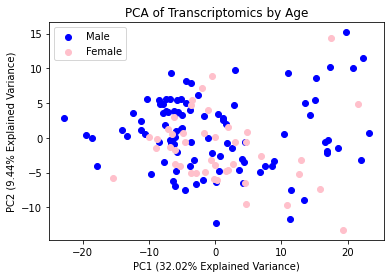

In [12]:
plt.scatter(maledf['PC1'], maledf['PC2'], label = 'Male', c='blue')
plt.scatter(femaledf['PC1'], femaledf['PC2'], label = 'Female', c='pink')
plt.legend()
plt.title("PCA of Transcriptomics by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.savefig('results/KEGG_pca_by_sex.png')

In [13]:
principledf_withouthgps = principledf.iloc[:-10]
principledf_onlyhgps = principledf.iloc[-10:]

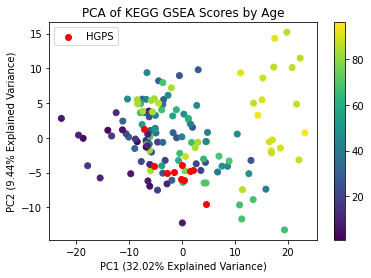

In [14]:
plt.scatter(principledf_withouthgps['PC1'], principledf_withouthgps['PC2'], c=principledf_withouthgps['age'], cmap='viridis')
plt.colorbar()
plt.scatter(principledf_onlyhgps['PC1'], principledf_onlyhgps['PC2'], c='red', label = 'HGPS')
plt.title("PCA of KEGG GSEA Scores by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.legend()
plt.savefig('results/KEGG_pca_by_age.png')

In [15]:
control_df

Term|NES,ABC transporters,AGE-RAGE signaling pathway in diabetic complications,AMPK signaling pathway,Acute myeloid leukemia,Adherens junction,Adipocytokine signaling pathway,Adrenergic signaling in cardiomyocytes,African trypanosomiasis,"Alanine, aspartate and glutamate metabolism",Alcoholism,Aldosterone synthesis and secretion,Aldosterone-regulated sodium reabsorption,Allograft rejection,Alzheimer disease,Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRNA biosynthesis,Amoebiasis,Amphetamine addiction,Amyotrophic lateral sclerosis (ALS),Antigen processing and presentation,Apelin signaling pathway,Apoptosis,Arachidonic acid metabolism,Arginine and proline metabolism,Arrhythmogenic right ventricular cardiomyopathy (ARVC),Ascorbate and aldarate metabolism,Asthma,Autoimmune thyroid disease,Autophagy,Axon guidance,B cell receptor signaling pathway,Bacterial invasion of epithelial cells,Basal cell carcinoma,Basal transcription factors,Base excision repair,Bile secretion,Biosynthesis of unsaturated fatty acids,Bladder cancer,Breast cancer,Butanoate metabolism,...,Steroid hormone biosynthesis,Synaptic vesicle cycle,Systemic lupus erythematosus,T cell receptor signaling pathway,TGF-beta signaling pathway,TNF signaling pathway,Taste transduction,Terpenoid backbone biosynthesis,Th1 and Th2 cell differentiation,Th17 cell differentiation,Thermogenesis,Thyroid cancer,Thyroid hormone signaling pathway,Thyroid hormone synthesis,Tight junction,Toll-like receptor signaling pathway,Toxoplasmosis,Transcriptional misregulation in cancer,Tryptophan metabolism,Tuberculosis,Type I diabetes mellitus,Type II diabetes mellitus,Tyrosine metabolism,Ubiquitin mediated proteolysis,VEGF signaling pathway,"Valine, leucine and isoleucine degradation",Vascular smooth muscle contraction,Vasopressin-regulated water reabsorption,Vibrio cholerae infection,Viral carcinogenesis,Viral myocarditis,Vitamin digestion and absorption,Wnt signaling pathway,alpha-Linolenic acid metabolism,beta-Alanine metabolism,cAMP signaling pathway,cGMP-PKG signaling pathway,mRNA surveillance pathway,mTOR signaling pathway,p53 signaling pathway
101_19yr_Female_Caucasian,-0.129857,0.258711,0.193693,0.201347,0.309602,0.174815,0.0614013,-0.0817682,0.0419525,0.105528,0.0138919,0.0352409,-0.161871,0.383755,0.340144,0.258828,0.109566,-0.0145487,0.209224,0.0292945,0.187216,0.254303,-0.12101,0.15979,0.0949463,-0.247524,-0.36199,-0.266613,0.300811,0.154509,0.167469,0.299391,0.0892466,0.248824,0.335416,-0.154319,0.267599,0.303138,0.118854,-0.00582288,...,-0.257187,0.0788105,-0.0785855,0.121168,0.224157,0.167226,-0.346207,0.330718,-0.00846725,0.0546164,0.333152,0.32112,0.230256,-0.0112221,0.146146,0.0694572,0.152501,0.0912505,0.00285182,0.0658225,-0.124877,0.00675952,-0.0365268,0.315311,0.233597,0.247112,0.0371971,0.24309,0.325343,0.278804,0.0805508,-0.160747,0.111576,-0.135205,0.13074,0.00868406,0.0841983,0.331145,0.211693,0.258965
102_19yr_Male_Caucasian,-0.116628,0.257554,0.20857,0.215295,0.318695,0.174081,0.0725585,-0.0808863,0.0288113,0.117374,0.0266821,0.0508368,-0.160716,0.396193,0.334213,0.246491,0.130237,-0.00510213,0.213191,0.0242353,0.193579,0.269454,-0.14619,0.165129,0.116342,-0.246657,-0.363689,-0.264764,0.318589,0.183515,0.172572,0.312773,0.0784008,0.235617,0.344981,-0.146254,0.268663,0.308458,0.118232,-0.0207552,...,-0.26659,0.108946,-0.0714104,0.123056,0.219172,0.160567,-0.32666,0.299579,-0.0240212,0.0329241,0.336124,0.322546,0.246302,0.00440595,0.143758,0.0706206,0.162808,0.0910674,-0.000780058,0.0673199,-0.13452,0.00739699,-0.027583,0.323733,0.237522,0.237043,0.0368733,0.265595,0.331369,0.290464,0.103901,-0.163662,0.111196,-0.100701,0.131548,0.00970422,0.0917152,0.325557,0.220838,0.279661
103_19yr_Male_Caucasian,-0.103424,0.250671,0.199642,0.200237,0.308847,0.173885,0.0756566,-0.0712728,0.0566846,0.105003,0.0227472,0.0437389,-0.186525,0.385366,0.324071,0.265125,0.110154,-0.0128951,0.208042,0.0102,0.178916,0.264904,-0.104037,0.161633,0.0987377,-0.231296,-0.407757,-0.289542,

In [16]:
pd.DataFrame(pca.components_.T, index=control_df.columns, columns=["PC1","PC2"]).sort_values("PC1",ascending=False).to_csv("data/KEGG_GSEA_PCA.csv")

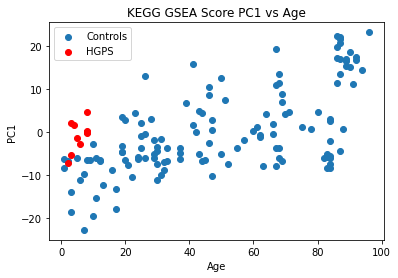

In [17]:
plt.scatter(principledf_withouthgps['age'], principledf_withouthgps['PC1'], label = "Controls")
plt.scatter(principledf_onlyhgps['age'], principledf_onlyhgps['PC1'], c = 'red', label = "HGPS")
plt.xlabel('Age')
plt.ylabel('PC1')
plt.title("KEGG GSEA Score PC1 vs Age")
plt.legend()
plt.savefig('results/KEGG_age_by_pc1.png')

In [18]:
from scipy import stats 

In [19]:
stats.spearmanr(principledf_withouthgps['age'], principledf_withouthgps['PC1'])

SpearmanrResult(correlation=0.619738019944162, pvalue=1.8165229011853235e-15)

In [20]:
control_df

Term|NES,ABC transporters,AGE-RAGE signaling pathway in diabetic complications,AMPK signaling pathway,Acute myeloid leukemia,Adherens junction,Adipocytokine signaling pathway,Adrenergic signaling in cardiomyocytes,African trypanosomiasis,"Alanine, aspartate and glutamate metabolism",Alcoholism,Aldosterone synthesis and secretion,Aldosterone-regulated sodium reabsorption,Allograft rejection,Alzheimer disease,Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRNA biosynthesis,Amoebiasis,Amphetamine addiction,Amyotrophic lateral sclerosis (ALS),Antigen processing and presentation,Apelin signaling pathway,Apoptosis,Arachidonic acid metabolism,Arginine and proline metabolism,Arrhythmogenic right ventricular cardiomyopathy (ARVC),Ascorbate and aldarate metabolism,Asthma,Autoimmune thyroid disease,Autophagy,Axon guidance,B cell receptor signaling pathway,Bacterial invasion of epithelial cells,Basal cell carcinoma,Basal transcription factors,Base excision repair,Bile secretion,Biosynthesis of unsaturated fatty acids,Bladder cancer,Breast cancer,Butanoate metabolism,...,Steroid hormone biosynthesis,Synaptic vesicle cycle,Systemic lupus erythematosus,T cell receptor signaling pathway,TGF-beta signaling pathway,TNF signaling pathway,Taste transduction,Terpenoid backbone biosynthesis,Th1 and Th2 cell differentiation,Th17 cell differentiation,Thermogenesis,Thyroid cancer,Thyroid hormone signaling pathway,Thyroid hormone synthesis,Tight junction,Toll-like receptor signaling pathway,Toxoplasmosis,Transcriptional misregulation in cancer,Tryptophan metabolism,Tuberculosis,Type I diabetes mellitus,Type II diabetes mellitus,Tyrosine metabolism,Ubiquitin mediated proteolysis,VEGF signaling pathway,"Valine, leucine and isoleucine degradation",Vascular smooth muscle contraction,Vasopressin-regulated water reabsorption,Vibrio cholerae infection,Viral carcinogenesis,Viral myocarditis,Vitamin digestion and absorption,Wnt signaling pathway,alpha-Linolenic acid metabolism,beta-Alanine metabolism,cAMP signaling pathway,cGMP-PKG signaling pathway,mRNA surveillance pathway,mTOR signaling pathway,p53 signaling pathway
101_19yr_Female_Caucasian,-0.129857,0.258711,0.193693,0.201347,0.309602,0.174815,0.0614013,-0.0817682,0.0419525,0.105528,0.0138919,0.0352409,-0.161871,0.383755,0.340144,0.258828,0.109566,-0.0145487,0.209224,0.0292945,0.187216,0.254303,-0.12101,0.15979,0.0949463,-0.247524,-0.36199,-0.266613,0.300811,0.154509,0.167469,0.299391,0.0892466,0.248824,0.335416,-0.154319,0.267599,0.303138,0.118854,-0.00582288,...,-0.257187,0.0788105,-0.0785855,0.121168,0.224157,0.167226,-0.346207,0.330718,-0.00846725,0.0546164,0.333152,0.32112,0.230256,-0.0112221,0.146146,0.0694572,0.152501,0.0912505,0.00285182,0.0658225,-0.124877,0.00675952,-0.0365268,0.315311,0.233597,0.247112,0.0371971,0.24309,0.325343,0.278804,0.0805508,-0.160747,0.111576,-0.135205,0.13074,0.00868406,0.0841983,0.331145,0.211693,0.258965
102_19yr_Male_Caucasian,-0.116628,0.257554,0.20857,0.215295,0.318695,0.174081,0.0725585,-0.0808863,0.0288113,0.117374,0.0266821,0.0508368,-0.160716,0.396193,0.334213,0.246491,0.130237,-0.00510213,0.213191,0.0242353,0.193579,0.269454,-0.14619,0.165129,0.116342,-0.246657,-0.363689,-0.264764,0.318589,0.183515,0.172572,0.312773,0.0784008,0.235617,0.344981,-0.146254,0.268663,0.308458,0.118232,-0.0207552,...,-0.26659,0.108946,-0.0714104,0.123056,0.219172,0.160567,-0.32666,0.299579,-0.0240212,0.0329241,0.336124,0.322546,0.246302,0.00440595,0.143758,0.0706206,0.162808,0.0910674,-0.000780058,0.0673199,-0.13452,0.00739699,-0.027583,0.323733,0.237522,0.237043,0.0368733,0.265595,0.331369,0.290464,0.103901,-0.163662,0.111196,-0.100701,0.131548,0.00970422,0.0917152,0.325557,0.220838,0.279661
103_19yr_Male_Caucasian,-0.103424,0.250671,0.199642,0.200237,0.308847,0.173885,0.0756566,-0.0712728,0.0566846,0.105003,0.0227472,0.0437389,-0.186525,0.385366,0.324071,0.265125,0.110154,-0.0128951,0.208042,0.0102,0.178916,0.264904,-0.104037,0.161633,0.0987377,-0.231296,-0.407757,-0.289542,

In [21]:
loo=LeaveOneOut()
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
n_genes=[]
y_pred=[]
y_act=[]
for train_index, test_index in loo.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

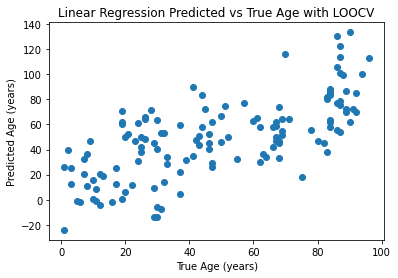

In [22]:
plt.scatter(y_act,y_pred)
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age with LOOCV")
plt.savefig('results/KEGG_pred_true_age_linreg.png')

In [24]:
np.mean(np.abs(np.array(y_act)-np.array(y_pred)))

19.4240700741605

In [26]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.693
p: 2.4752539516610334e-20


PCA on Controls Only

In [27]:
labels = control_df.index
ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
sex = [int(label.lower().split('_')[2] == 'male') for label in labels]
race = [label.lower().split('_')[3] for label in labels]

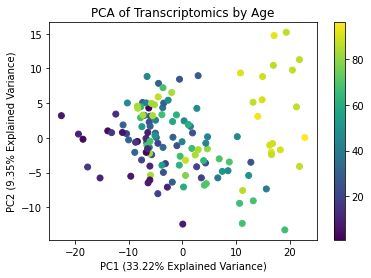

In [29]:
total_numpy = control_df.to_numpy()
pca = PCA(n_components=2)
scaler = StandardScaler()
x = scaler.fit_transform(total_numpy)
principlecomponents = pca.fit_transform(x)
principledf = pd.DataFrame(principlecomponents)
principledf.columns = ['PC1', 'PC2']
principledf['age'] = ages
principledf['sex'] = sex
plt.scatter(principledf['PC1'], principledf['PC2'], c=principledf['age'], cmap='viridis')
plt.colorbar()
plt.title("PCA of Transcriptomics by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.savefig('results/KEGG_pred_true_age_linreg_onlycontrols.png')

In [30]:
ls=pd.DataFrame(pca.components_.T, index=control_df.columns, columns=["PC1","PC2"]).sort_values("PC1",ascending=False)

In [31]:
l=list(ls.iloc[0:10,:].index)
l.extend(ls.iloc[-10:,:].index)

In [32]:
print(len(l))

20


In [33]:
l

['Autophagy',
 'Mitophagy',
 'HIF-1 signaling pathway',
 'Longevity regulating pathway',
 'Kaposi sarcoma-associated herpesvirus infection',
 'Relaxin signaling pathway',
 'Insulin resistance',
 'Endocytosis',
 'Choline metabolism in cancer',
 'Chagas disease (American trypanosomiasis)',
 'Nucleotide excision repair',
 'Olfactory transduction',
 'Oocyte meiosis',
 'Homologous recombination',
 'Progesterone-mediated oocyte maturation',
 'Mismatch repair',
 'Cell cycle',
 'Fanconi anemia pathway',
 'DNA replication',
 'Base excision repair']

In [34]:
control_df[l]

Term|NES,Autophagy,Mitophagy,HIF-1 signaling pathway,Longevity regulating pathway,Kaposi sarcoma-associated herpesvirus infection,Relaxin signaling pathway,Insulin resistance,Endocytosis,Choline metabolism in cancer,Chagas disease (American trypanosomiasis),Nucleotide excision repair,Olfactory transduction,Oocyte meiosis,Homologous recombination,Progesterone-mediated oocyte maturation,Mismatch repair,Cell cycle,Fanconi anemia pathway,DNA replication,Base excision repair
101_19yr_Female_Caucasian,0.300811,0.411481,0.227139,0.204395,0.196937,0.200184,0.170613,0.306391,0.181186,0.162133,0.374306,-0.466854,0.212418,0.204449,0.197461,0.352004,0.338167,0.167523,0.380181,0.335416
102_19yr_Male_Caucasian,0.318589,0.424795,0.227692,0.217506,0.190726,0.206926,0.184469,0.319902,0.195259,0.168162,0.374638,-0.472225,0.222099,0.207284,0.21136,0.359253,0.339376,0.171746,0.385038,0.344981
103_19yr_Male_Caucasian,0.310864,0.419004,0.215251,0.206352,0.192528,0.20241,0.183477,0.314983,0.190353,0.164489,0.359942,-0.468985,0.214542,0.177954,0.205075,0.321764,0.327787,0.14887,0.344135,0.33183
104_19yr_Male_Caucasian,0.307579,0.413091,0.222795,0.209611,0.190155,0.201233,0.179122,0.307939,0.188177,0.155092,0.362781,-0.469243,0.214945,0.179361,0.203729,0.321781,0.324957,0.159208,0.350371,0.337408
105_20yr_Male_Caucasian,0.300494,0.41328,0.21956,0.199187,0.19651,0.19613,0.175976,0.300295,0.181119,0.169072,0.381704,-0.469114,0.23011,0.211272,0.215749,0.367113,0.354675,0.186415,0.399525,0.353755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.312557,0.41872,0.222888,0.204805,0.194367,0.200596,0.181917,0.303565,0.180326,0.161373,0.392884,-0.463526,0.223794,0.217509,0.215309,0.377033,0.35103,0.183269,0.402608,0.344205
95_13yr_Male_WhiTEEASTINDIAN,0.300575,0.405592,0.219269,0.196842,0.197052,0.195314,0.169657,0.298438,0.179672,0.157685,0.395409,-0.460509,0.233229,0.229059,0.220136,0.378487,0.356486,0.198683,0.407578,0.356599
97_16yr_Female_Unknown,0.29865,0.410233,0.221333,0.197442,0.196238,0.200444,0.163776,0.298174,0.182767,0.162942,0.385211,-0.466001,0.230549,0.220814,0.216782,0.377766,0.356609,0.191912,0.404684,0.347971
98_17yr_Male_Caucasian,0.287317,0.395167,0.205157,0.191053,0.177813,0.191265,0.159939,0.29542,0.167606,0.154068,0.371856,-0.459315,0.208408,0.190576,0.199139,0.345687,0.322209,0.163574,0.369164,0.354881


In [35]:
loo=LeaveOneOut()
X=control_df[l]
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
n_genes=[]
y_pred=[]
y_act=[]
for train_index, test_index in loo.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

In [ ]:
# loo=LeaveOneOut()
# X=control_df
# X=X.reset_index()
# X=X.drop(["index"], axis=1)
# labels = list(control_df.index)
# control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
# y=np.array(control_ages)
# n_genes=[]
# y_pred=[]
# y_act=[]
# for train_index, test_index in loo.split(X):
#   X_train, X_test = X.loc[train_index], X.loc[test_index]
#   n_genes.append(X_train.shape[1])
#   y_train, y_test = y[train_index], y[test_index]
#   reg=svm.SVR(kernel='linear').fit(X_train,y_train)
#   y_pred.append(reg.predict(X_test))
#   y_act.append(y_test)
# y_pred = np.array([y[0] for y in y_pred])
# y_act = np.array([y[0] for y in y_act])

In [36]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.566
p: 1.2383557790537062e-12


In [ ]:
def make_labels(y,K):
  classifiers_ranges=get_ranges(y,K)
  y_mod=[]
  classifier_classes=np.zeros((K,len(y)))
  for i in range(K):
    for j in range(len(y)):
      for k in range(len(classifiers_ranges[i])):
        if y[j] in classifiers_ranges[i][k]:
          classifier_classes[i,j]=k
          break
  return classifier_classes, classifiers_ranges

In [ ]:
def get_ranges(y,K):
  classifiers_ranges=[]
  for i in range(K):
    classifier_ranges=[]
    classifier_ranges.append(list(range(0,i+1)))
    j=i+1
    while j<y.max():
      classifier_ranges.append(list(range(j,j+K+1)))
      j+=K+1
    classifiers_ranges.append(classifier_ranges)
  return classifiers_ranges

In [ ]:
def ensemble_voting(X_train,y_train,X_test,K):
  y_trans, classifiers_ranges=make_labels(y_train,K)
  y_pred_cat=[]
  for i in range(len(y_trans)):
    # clf = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto")
    clf= SVC(kernel='poly')
    clf.fit(X_train, y_trans[i])
    y_pred_cat.extend(classifiers_ranges[i][int(clf.predict([X_test])[0])])
  d=dict(collections.Counter(y_pred_cat))
  return max(d.items(),key=operator.itemgetter(1))[0]

  


In [ ]:
def loocv(X, y, K):
  loo=LeaveOneOut()
  n_genes=[]
  y_pred=[]
  y_act=[]
  i=0
  for train_index, test_index in loo.split(X):
    i+=1
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    y_pred.append(ensemble_voting(X_train,y_train,X_test.iloc[0],K))
    y_act.append(y_test[0])
    print(i,y_pred[-1],y_test[0])
  return y_pred, y_act

In [ ]:
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
y_pred, y_act=loocv(X,y,20)

1 29 19
2 24 19
3 24 19
4 29 19
5 29 20
6 24 20
7 23 31
8 23 31
9 23 32
10 23 32
11 23 33
12 23 33
13 23 37
14 23 37
15 23 37
16 23 39
17 29 51
18 26 52
19 24 55
20 29 57
21 24 60
22 83 71
23 29 75
24 26 78
25 29 80
26 86 94
27 86 89
28 86 87
29 86 90
30 86 89
31 86 86
32 86 92
33 86 87
34 26 1
35 24 12
36 29 22
37 23 25
38 23 29
39 29 24
40 29 23
41 83 26
42 29 21
43 29 24
44 83 67
45 79 67
46 86 68
47 26 82
48 24 66
49 83 68
50 24 70
51 26 69
52 29 25
53 29 25
54 23 26
55 29 26
56 23 28
57 23 29
58 23 29
59 23 30
60 23 30
61 23 30
62 26 30
63 23 43
64 83 44
65 23 41
66 26 47
67 86 50
68 83 46
69 26 50
70 26 42
71 24 47
72 83 41
73 26 43
74 26 44
75 26 45
76 83 46
77 26 46
78 26 47
79 29 61
80 29 62
81 29 62
82 26 63
83 83 64
84 24 66
85 29 67
86 26 67
87 29 68
88 26 68
89 86 69
90 29 69
91 29 83
92 26 83
93 26 83
94 29 84
95 26 84
96 29 84
97 26 84
98 26 84
99 26 84
100 26 84
101 86 86
102 87 86
103 87 86
104 86 87
105 83 87
106 86 87
107 86 87
108 24 88
109 86 89
110 86 90
111 86 91

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Linear Regression Predicted vs True Age with LOOCV')

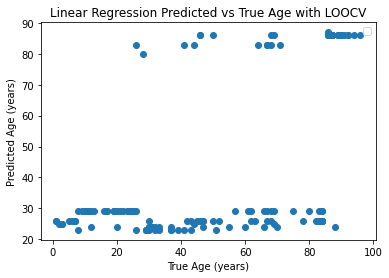

In [ ]:
plt.scatter(y_act,y_pred)
plt.legend()
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age with LOOCV")

In [ ]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.772
p: 1.6491049024778758e-27


In [ ]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.676
p: 4.290127614258719e-19


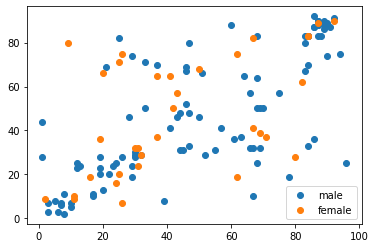

In [ ]:
male=[(x[0], x[1]) for x in zip(y_act,y_pred,sex) if x[2]==1]
female=[(x[0], x[1]) for x in zip(y_act,y_pred,sex) if x[2]==0]
plt.scatter([x[0] for x in male], [x[1] for x in male], label="male")
plt.scatter([x[0] for x in female], [x[1] for x in female], label="female")
plt.legend()

In [ ]:
np.mean([np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==1])

14.363636363636363

In [ ]:
np.mean([np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==0])

18.176470588235293

In [ ]:
import scip

In [ ]:
stats.ttest_ind([np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==1],[np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==0])

Ttest_indResult(statistic=-1.1282424070758765, pvalue=0.26127961289658336)

Binarization

In [ ]:
def bhainerize(y, threshold):
  return [int(yi>threshold) for yi in y]

In [ ]:
from sklearn.linear_model

In [ ]:
thresholds=np.linspace(np.array(control_ages).min(),np.array(control_ages).max(),np.array(control_ages).max()-np.array(control_ages).min())
accuracies=[]
for threshold in thresholds:
  loo=LeaveOneOut()
  X=control_df
  X=X.reset_index()
  X=X.drop(["index"], axis=1)
  labels = list(control_df.index)
  control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
  y=np.array(bhainerize(np.array(control_ages),threshold))
  n_genes=[]
  y_pred=[]
  y_act=[]
  for train_index, test_index in loo.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    reg=LogisticRegression().fit(X_train,y_train)
    y_pred.append(reg.predict(X_test))
    y_act.append(y_test)
  y_pred = np.array([y[0] for y in y_pred])
  y_act = np.array([y[0] for y in y_act])
  accuracies.append(np.mean([int(x[0]==x[1]) for x in zip(y_pred,y_act) ]))
  print(accuracies[-1])

0.9849624060150376
0.9774436090225563
0.9624060150375939
0.9624060150375939
0.9548872180451128
0.9473684210526315
0.9323308270676691
0.9172932330827067
0.9097744360902256
0.8947368421052632
0.8796992481203008
0.8646616541353384
0.8571428571428571
0.8571428571428571
0.8571428571428571
0.849624060150376
0.8345864661654135
0.8345864661654135
0.8045112781954887
0.7894736842105263
0.7819548872180451
0.7744360902255639
0.7669172932330827
0.7518796992481203
0.7293233082706767
0.706766917293233
0.706766917293233
0.6992481203007519
0.6766917293233082
0.6616541353383458
0.6616541353383458
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6766917293233082
0.6992481203007519
0.706766917293233
0.6992481203007519
0.7142857142857143
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6992481203007519
0.6992481203007519
0.706766917293233
0.706766917293233

ValueError: ignored

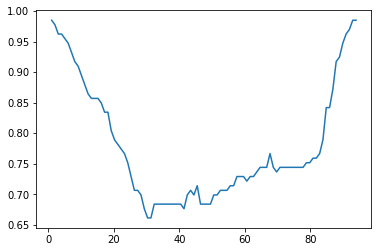

In [ ]:
plt.plot(thresholds[0:len(accuracies)], accuracies)